In [2]:
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from scipy.special import gamma, hyp2f1
from scipy.ndimage import shift
import multiprocessing


In [3]:
def antialias(phin,imagepix,beam_ratio,Nact):
	'''
	anti-alias via a butterworth filter
	'''
	xy=xy_plane(imagepix)
	buttf = lambda rgrid,eps,r0,n: 1./np.sqrt(1+eps**2.*(xy/r0)**n) #butterworth filter
	phinput=phin-np.min(phin)
	phfilt=np.abs(pupil_to_image(np.fft.fftshift(image_to_pupil(phinput))*(buttf(xy,1,Nact/2*beam_ratio*0.99,100)))) #Nact actuators across the pupil
	phout=phfilt-np.mean(phfilt)
	return phout


def CM(mag, t_int, i_amp, narrow=False):
	im_fourier = image(mag, t_int, i_amp, 'fourier', narrow) - image(mag, t_int, i_amp, 'none', narrow)
	im_zernike = image(mag, t_int, i_amp, 'zernike', narrow) - image(mag, t_int, i_amp, 'none', narrow)
	
	IM = np.hstack([im_fourier.ravel().reshape(-1, 1), im_zernike.ravel().reshape(-1,1)])

	cm = pinv(IM, rcond=1e-10)
	return cm

def complex_amplitude(mag,phase):
	'''
	complex amplitude in terms of magnitude and phase
	'''
	return mag*np.cos(phase)+1j*mag*np.sin(phase)

def fourier(im_pix, pup_pix):
	'''
	high freq diagonal mode 
	'''
	rho, _ = polar_grid(im_pix, pup_pix)
	x = np.linspace(0 , np.pi, im_pix)
	y = np.linspace(0, np.pi, im_pix)
	X, Y = np.meshgrid(x, y)
	mode = np.sin(14*(X - Y))
	mode = np.where(rho>0, mode, rho)
	return mode  

def image_to_pupil(im):
	return np.fft.ifft2(im,norm='ortho')

def intensity(wavefront):
	 return (np.abs(wavefront))**2.

def make_noise_pl(wavefronterror,imagepix,pupilpix,wavelength,pl):
	'''
	make noise with a user input power law:

	(1) take white noise in image plane
	(2) IFFT to pupil plane
	(3) weight complex pupil plane (spatial frequency) by -1 power law (power~amplitude**2~x**(-2), so amplitude goes as (x**(-2))**(1/2)=x(-1)
	(4) FFT back to image plane

	wavefronterror = rms WFE (nm)
	'''

	white_noise=np.random.random((imagepix,imagepix))*2.*np.pi #phase
	#noisefft=np.fft.fftshift(np.fft.fft2(white_noise))
	xy=xy_plane(imagepix)
	#grid=np.mgrid[0:imagepix,0:imagepix]
	#xy=np.sqrt((grid[0])**2.+(grid[1])**2.)
	amplitude=(xy+1)**(pl/2.) #amplitude central value in xy grid is one, so max val is one in power law, everything else lower

	#make all spatial frequencies below 1/Dpup/10 into a tophat function
	ind=np.where(np.abs(xy-(pupilpix/2.)/10.)==np.min(np.abs(xy-(pupilpix/2.)/10.)))
	amplitude=(xy+1)**(-1.)*xy[ind][0]
	amplitude[np.where(xy<(pupilpix/2.)/10.)]=1.
	amp_step_val=amplitude[np.where(np.abs(xy-(pupilpix/2.)/10.)==np.min(np.abs(xy-(pupilpix/2.)/10.)))][0]
	amplitude[np.where(xy<(pupilpix/2.)/10.)]=amp_step_val

	amplitude[int(imagepix/2),int(imagepix/2)]=0. #remove piston

	#remove alaising effects by cutting off power law just before the edge of the image
	amplitude[np.where(xy>imagepix/2.-1)]=0.

	amp=shift(amplitude,(-imagepix/2.,-imagepix/2.),mode='wrap')
	image_wavefront=complex_amplitude(amp,white_noise)
	noise_wavefront=np.real(np.fft.fft2(image_wavefront))
	norm_factor=(wavefronterror/wavelength*2.*np.pi)/np.std(noise_wavefront[np.where(xy<pupilpix/2.)]) #normalization factor for phase error over the pupil
	phase_out_ini=noise_wavefront*norm_factor

	phase_out=remove_tt(phase_out_ini,imagepix,pupilpix) #tip tilt removed phase screen

	return phase_out

def phase(wavefront):
	return np.arctan2(np.imag(wavefront),np.real(wavefront))

def polar_grid(imagepix,pupilpix):
	'''
	make a polar image grid from a cartesian grid
	'''
	grid=np.mgrid[0:imagepix,0:imagepix]
	xy=np.sqrt((grid[0]-imagepix/2.)**2.+(grid[1]-imagepix/2.)**2.)
	xy[np.where(xy>pupilpix/2.)]=0.
	rad_norm=xy/np.max(xy)
	phi=np.arctan2(grid[1]-imagepix/2.,grid[0]-imagepix/2.)
	return rad_norm,phi

def pupil_to_image(im):
	return np.fft.fft2(im,norm='ortho')

def remove_tt(im_tar_phase,imagepix,pupilpix):
	'''
	remove tip and tilt

	input:
	im_tar_phase = normal input phase screen generated from some power law
	imagepix = width of focal plane image in pixels
	pupilpix = width of pupil in pixels

	output: phase screen with tip and tilt removed from the pupil
	'''

	xy=xy_plane(imagepix)
	phase_screen=im_tar_phase-np.mean(im_tar_phase[np.where(xy<pupilpix/2.)]) #remove piston in the pupil just by changing to zero mean

	rho,phi=polar_grid(imagepix,pupilpix)

	zern_nm=[]
	for n in range(1,2): #remove tip,tilt zernikes
		m=range(-1*n,n+2,2)
		for mm in m:
			zern_nm.append([n,mm])

	#reference array
	refarr=np.zeros((len(zern_nm),imagepix**2))
	for i in range(len(zern_nm)):
		z=zernike(zern_nm[i][0],zern_nm[i][1],rho,phi)
		refarr[i]=z.flatten()

	#covariance matrix:
	n=len(zern_nm)
	cov=np.zeros((n,n))
	for i in range(n):
		for j in range(i+1):
			if cov[j,i]==0.:
				cov[i,j]=np.sum(refarr[i,:]*refarr[j,:])
				cov[j,i]=cov[i,j]
			#print i*n+j,n**2-1
	covinv=np.linalg.pinv(cov,rcond=1e-7)

	#correlation image vector:
	tar=np.ndarray.flatten(phase_screen)
	cor=np.zeros((n,1))
	for i in range(n):
		cor[i]=np.sum(refarr[i]*tar)
		#print i, n-1

	coeffs=np.dot(covinv,cor)

	all_zern=np.dot(coeffs.T,refarr).reshape(imagepix,imagepix)
	out_phase=phase_screen-all_zern
	return out_phase	


	return cm @ T

def xy_plane(dim):
	'''
	define xy plane to use for future functions
	'''
	grid=np.mgrid[0:dim,0:dim]
	xy=np.sqrt((grid[0]-dim/2.)**2.+(grid[1]-dim/2.)**2.)
	return xy

def zernike(n,m,rho,phi):
	'''
	from psfs.py
	make a zernike polynomial of specified n,m given input polar coordinate maps of rho (normalized to one; pupil coordinates only) and phi (radians)
	'''
	rad=gamma(n+1)*hyp2f1(-1./2.*(m+n),1./2.*(m-n),-n,rho**(-2))/gamma(1./2.*(2+n-m))/gamma(1./2.*(2+n+m))*rho**n
	if m>=0:
		cos=np.cos(m*phi)
		out=rad*cos
	else:
		sin=np.sin(-1*m*phi)
		out=rad*sin
	out[np.where(np.isnan(out)==True)]=0.
	return out

def signal_coeff(mag, t_int, amp, cm):
	'''
	return coefficients for signal pl wfe
	'''
	pl_wfe = image(mag, t_int, amp, wfe_phase='pl', phn=False, readn=False) 
	T = pl_wfe.ravel().reshape(-1, 1)

	return cm @ T

def image(mag, t_int, amp, wfe_phase, narrow=False, alias_filter=False, phn=False, readn= False):

	wavelength = 1.275e-6 # middle of bandpass
	beam_ratio = 3.75
	imagepix = 240 # size of total image
	pupilpix = imagepix/beam_ratio # size of pupil image
	
	grid = np.mgrid[0:imagepix, 0:imagepix] # two grids 128 x 128, all rows from 0 -> 127
	xy_dh = np.sqrt( (grid[1] - imagepix/2.)**2 + (grid[0] - imagepix/2.)**2 ) # grid of distances from center of grid
	aperature = np.zeros((imagepix, imagepix)) # grid of zeros, unobscured aperature
	
	p_obs = 0.3 # how much to obsure aperature
	aperature[np.where(np.logical_and( xy_dh > p_obs * pupilpix/2, xy_dh < pupilpix/2))] = 1. # creates ring with 1's bounded, zeros everywhere. OD~28 ID~8	
	indpup = np.where(aperature == 1.) # return boolean value where ring is filled with ones
	rho, phi = polar_grid(imagepix, pupilpix) # clockwise grid from pi to -pi
	rphi = -phi + np.pi # clockwise grid from 0 to 2pi

	xtlt = (grid[1] - imagepix/2 + 0.5)/beam_ratio # gradient along x on grid from -beam (left) to +beam (right)
	ytlt = (grid[0] - imagepix/2 + 0.5)/beam_ratio # gradiend along y on grid from -beam (top) to +beam (bottom)

	pwfs = np.zeros(aperature.shape)
	ind1 = np.where(np.logical_and(rphi >= 0, rphi < 2*np.pi/3))
	ind2 = np.where(np.logical_and(rphi >= 2*np.pi/3, rphi < 2*np.pi*2/3))
	ind3 = np.where(np.logical_and(rphi >= 2*np.pi*2/3, rphi < 2* np.pi))


	nact = 32
	if narrow==False:
		fudge=3.
	if narrow==True:
		fudge=4.5
	

	ff = -0.6 # for centering
	g1 = (xtlt - ytlt)*np.sqrt(2) - ff*ytlt # gradient along y=x line roughly
	g2 = ytlt - ff*ytlt # gradient neg (top) to pos (down) 
	g3 = (-xtlt - ytlt)*np.sqrt(2) - ff*ytlt # gradient along y=-x
	tt1, tt2, tt3 = g1*fudge, g2*fudge, g3*fudge

	# gradient zero at center in pyramid apex pattern
	pwfs[ind1] = tt1[ind1] # 1st 3rd cw
	pwfs[ind2] = tt2[ind2]	# 2nd 3rd cw
	pwfs[ind3] = tt3[ind3] # 3rd 3rd cw

	Dtel = 3 # diameter of aperature
	bandpass = 0.65/1.275 # bandpass fraction, range over mean
	percent_bandpass = 0.5
	f0 = 192.9 * (wavelength * (percent_bandpass/bandpass)*1e6)*10**8. # photons/m^2 s, mag 0 star, 50% bandpass

	flux_ini = f0 * 10.**(-mag/2.5)
	tr_atm = 0.3 # transmission through atmosphere
	th = 0.2 # instrument throughput
	qe = 0.75 # quantum efficiency of CCD
	flux = flux_ini * tr_atm * th * qe
	num_photon = flux * t_int * np.pi*(Dtel/2.)**2.

	if narrow==True:
		lim = pupilpix/1.5
		pwfs[np.where(np.logical_or(np.logical_or(xtlt>lim/2,xtlt<-lim/2),np.logical_or(ytlt>lim/2,ytlt<-lim/2)))]=0
		
	if narrow==False:
		FoVlim = pupilpix
		pwfs[np.where(np.logical_or(np.logical_or(xtlt>FoVlim/2,xtlt<-FoVlim/2),np.logical_or(ytlt>FoVlim/2,ytlt<-FoVlim/2)))]=0
		

	#return pwfs
	def propagate(wfe_phase, aperature):
		pupil_wavefront_dm_unnorm =  aperature * np.exp(1j*wfe_phase * amp) 
		norm_phot = np.sum(intensity(np.ones((imagepix, imagepix))[indpup]))
		pupil_wavefront_dm = complex_amplitude(np.sqrt(intensity(pupil_wavefront_dm_unnorm)/norm_phot*num_photon),phase(pupil_wavefront_dm_unnorm))

		fpm_wavefront_ini = np.fft.fftshift(pupil_to_image(pupil_wavefront_dm)) # ft to image plane
		fpm_wavefront = complex_amplitude(np.abs(fpm_wavefront_ini), np.angle(fpm_wavefront_ini) + pwfs)
		pup_wf = image_to_pupil(fpm_wavefront) # ift to pupil plane
		im = intensity(pup_wf)
		
		if phn:
			noise = np.random.poisson(im) 
			return noise 
		else:
			return im
	
	# no wavefront error
	if wfe_phase == 'none':
		wfe_phase = np.ones_like(aperature)

	# power law wavefront error
	elif wfe_phase == 'pl':
		wavefronterror=100e-9/wavelength*2*np.pi #m rms wavefront error
		wfe_phase = make_noise_pl(wavefronterror, imagepix, pupilpix, -2, 16)

	# fourier wavefront error
	elif wfe_phase == 'fourier':
		wfe_phase = fourier(imagepix, imagepix)
		

	# zernike wavefront error
	elif wfe_phase == 'zernike':
		wfe_phase =  zernike(4, 4, rho, phi)

	# chech whether to run antialias 
	if alias_filter:
		phout = antialias(wfe_phase, imagepix, beam_ratio, nact)
	else:
		phout = wfe_phase

	im = propagate(phout, aperature)

	# read noise
	n_noise = 0
	if readn:
		read_noise_level = 30
		read_noise = np.random.poisson(np.ones_like(im) * read_noise_level)
		n_noise = read_noise
	return (im + n_noise)/np.sum(im)


/var/folders/36/fs_76ggd30x5h_4nhh6_2qnr00236f/T/ipykernel_26852/1748164622.py:173: RuntimeWarning: divide by zero encountered in power
  rad=gamma(n+1)*hyp2f1(-1./2.*(m+n),1./2.*(m-n),-n,rho**(-2))/gamma(1./2.*(2+n-m))/gamma(1./2.*(2+n+m))*rho**n


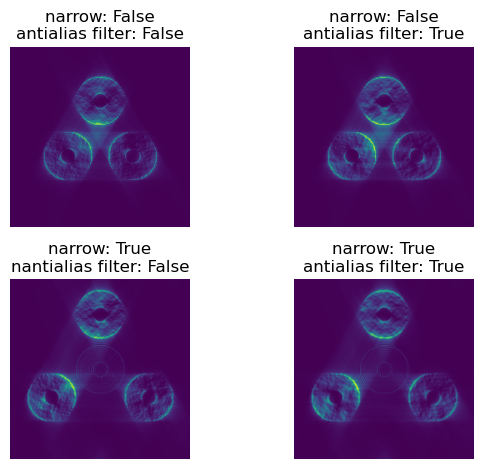

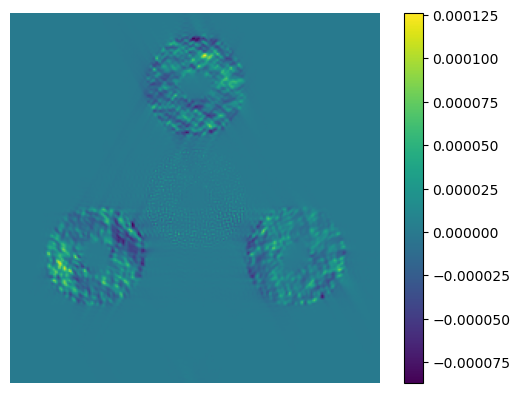

In [5]:
def images(amplitude = 0.15):
	magnitude = 5
	time = 0.001

	im_1 = image(mag=magnitude, t_int=time, amp=amplitude, wfe_phase='pl',
				narrow=False, alias_filter=False, phn=False, readn=False)

	im_2 = image(mag=magnitude, t_int=time, amp=amplitude, wfe_phase='pl',
				narrow=False, alias_filter=True, phn=False, readn=False)

	im_3 = image(mag=magnitude, t_int=time, amp=amplitude, wfe_phase='pl',
				narrow=True, alias_filter=False, phn=False, readn=False)

	im_4 = image(mag=magnitude, t_int=time, amp=amplitude, wfe_phase='pl',
				narrow=True, alias_filter=True, phn=False, readn=False)

	return im_1, im_2, im_3, im_4


im_1, im_2, im_3, im_4 = images()

ims = [[im_1, im_2], 
		[im_3, im_4]]
hdr = [['narrow: False\nantialias filter: False', 'narrow: False\nantialias filter: True'], 
		['narrow: True\nnantialias filter: False', 'narrow: True\nantialias filter: True']]
row, col = 2, 2

fig, axs = plt.subplots(nrows=row, ncols=col)
for i in range(row):
	for j in range(col):
		axs[i][j].imshow(ims[i][j])
		axs[i][j].set_axis_off()
		axs[i][j].set_title(hdr[i][j])
fig.tight_layout()


plt.figure()
plt.imshow(image(mag=5, t_int=0.001, amp=0.15, wfe_phase='pl',
				narrow=True, alias_filter=False, phn=False, readn=False) - image(mag=5, t_int=0.001, amp=0.15, wfe_phase='none',
				narrow=True, alias_filter=False, phn=False, readn=False))
plt.axis('off')
plt.colorbar()
plt.show()

In [ ]:
# parameters
mag = 5
t_int = 0.001
amp = 0.15

n = 500

f_1, z_1 = np.zeros(n), np.zeros(n)
f_2, z_2 = np.zeros(n), np.zeros(n)
f_3, z_3 = np.zeros(n), np.zeros(n)
f_4, z_4 = np.zeros(n), np.zeros(n)

# create a command matrix
cm_shallow = CM(mag, t_int, amp, narrow=False)
cm_narrow = CM(mag, t_int, amp, narrow=True)

for i in range(n):
	im_1, im_2, im_3, im_4 = images()

	T_1 = im_1.ravel().reshape(-1, 1)
	T_2 = im_2.ravel().reshape(-1, 1)
	T_3 = im_3.ravel().reshape(-1, 1)
	T_4 = im_4.ravel().reshape(-1, 1)


	f_1[i], z_1[i] = (cm_shallow @ T_1).flatten()
	f_2[i], z_2[i] = (cm_shallow @ T_2).flatten() # aliased
	f_3[i], z_3[i] = (cm_narrow @ T_3).flatten()
	f_4[i], z_4[i] = (cm_narrow @ T_4).flatten() # aliased

	# if unaliased is neg, make positive coeff
	if (f_1[i]<0):
		f_1[i]*=-1

	if (z_1[i]<0):
		z_1[i]*=-1

	if (f_3[i]<0):
		f_3[i]*=-1

	if (z_3[i]<0):
		z_3[i]*=-1

diff_top_f = (f_2-f_1)*amp
diff_top_z = (z_2-z_1)*amp
diff_bottom_f = (f_4-f_3)*amp
diff_bottom_z = (z_4-z_3)*amp
 
print('full pl wfe')
print('-----------------------------------')
print(np.mean(f_1), np.mean(z_1))
print(np.mean(f_2), np.mean(z_2))
print(np.mean(f_3), np.mean(z_3))
print(np.mean(f_4), np.mean(z_4))


/var/folders/36/fs_76ggd30x5h_4nhh6_2qnr00236f/T/ipykernel_19741/1748164622.py:173: RuntimeWarning: divide by zero encountered in power
  rad=gamma(n+1)*hyp2f1(-1./2.*(m+n),1./2.*(m-n),-n,rho**(-2))/gamma(1./2.*(2+n-m))/gamma(1./2.*(2+n+m))*rho**n


full pl wfe
-----------------------------------
0.4062900738951203 0.36614576777434027
0.3850512472290128 -0.19299398400600287
0.47857982283672257 0.39346071181852005
0.4782414235774829 -0.2439335558088489


<>:38: SyntaxWarning: invalid escape sequence '\c'
<>:38: SyntaxWarning: invalid escape sequence '\c'
/var/folders/36/fs_76ggd30x5h_4nhh6_2qnr00236f/T/ipykernel_19741/2335654652.py:38: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('CM $\cdot$ T * i_amp (peak-to-valley radians WFE)')
/var/folders/36/fs_76ggd30x5h_4nhh6_2qnr00236f/T/ipykernel_19741/1748164622.py:173: RuntimeWarning: divide by zero encountered in power
  rad=gamma(n+1)*hyp2f1(-1./2.*(m+n),1./2.*(m-n),-n,rho**(-2))/gamma(1./2.*(2+n-m))/gamma(1./2.*(2+n+m))*rho**n


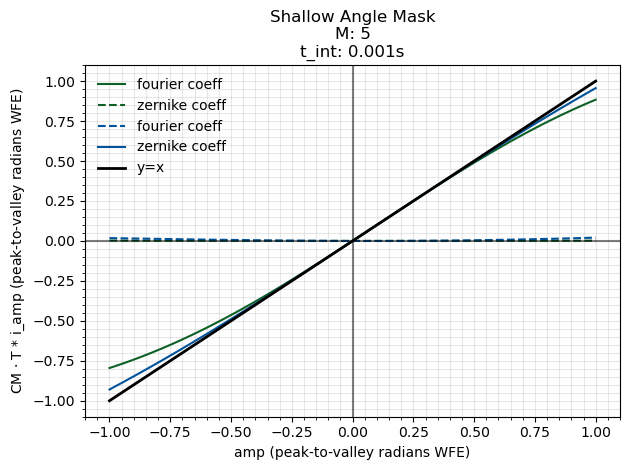

In [6]:
# Check linear response
def check(mag, t_int, i_amp):
	
	cm_shallow = CM(mag, t_int, i_amp, narrow=False)
	cm_narrow = CM(mag, t_int, i_amp, narrow=True)

	bound = 1
	amp = np.linspace(-bound, bound, 100)
	four_amp_f = np.zeros_like(amp)
	zern_amp_f = np.zeros_like(amp)
	four_amp_z = np.zeros_like(amp)
	zern_amp_z = np.zeros_like(amp)
	for i in range(len(amp)):
		out_fourier = image(mag, t_int, amp[i], 'fourier', narrow=False, alias_filter=False) - image(mag, t_int, amp[i], 'none', narrow=False, alias_filter=False)
		out_zernike = image(mag, t_int, amp[i], 'zernike', narrow=False, alias_filter=False) - image(mag, t_int, amp[i], 'none', narrow=False, alias_filter=False)
		#out_zernike = image(mag, t_int, amp[i], 'fourier') - image(mag, t_int, amp[i], 'none')
		T = np.hstack([out_fourier.ravel().reshape(-1,1), out_zernike.ravel().reshape(-1,1)])
		PHI = cm_shallow @ T # change to narrow and set narrow to True in out_fourier, out_zernike
		four_amp_f[i] = PHI[0][0] * i_amp
		zern_amp_f[i] = PHI[0][1] * i_amp
		four_amp_z[i] = PHI[1][0] * i_amp
		zern_amp_z[i] = PHI[1][1] * i_amp
		#print(f'\n{PHI}\n')

	plt.figure()
	plt.title(f'Shallow Angle Mask\nM: {mag}\nt_int: {t_int}s')
	#plt.plot(amp, amp, label='y=x', ls='-', c='grey')
	plt.plot(amp, four_amp_f, label='fourier coeff', ls='-', c=(14/255, 96/255, 39/255))
	plt.plot(amp, zern_amp_f, label='zernike coeff', ls='--', c=(14/255, 96/255, 39/255))
	plt.plot(amp, four_amp_z, label='fourier coeff', ls='--', c=(0/255, 83/255, 154/255))
	plt.plot(amp, zern_amp_z, label='zernike coeff', ls='-', c=(0/255, 83/255, 154/255))
	plt.plot(amp, amp, label='y=x', c='k', linewidth=2)
	plt.legend(framealpha=0)
	plt.grid(which='both', alpha = 0.15, c='dimgrey', zorder=0)
	plt.minorticks_on()
	plt.axhline(y=0, color='k', alpha=0.5)
	plt.axvline(x=0, color='k', alpha=0.5)
	plt.ylabel('CM $\cdot$ T * i_amp (peak-to-valley radians WFE)')
	plt.xlabel('amp (peak-to-valley radians WFE)')
	plt.tight_layout()
	#plt.savefig('./plots/linear_test.png', transparent=True, dpi=400)
	plt.show()

check(5, 0.001, 0.15)

antialias: false
	fourier diff: -0.00318582399991612
	zernike diff: -0.08387096276705146


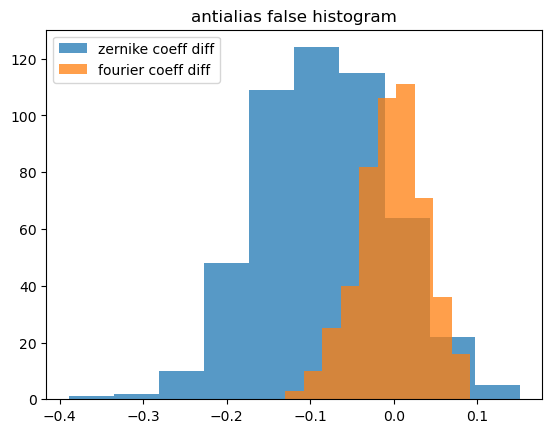

antialias: true
	fourier diff: -5.075988888594485e-05
	zernike diff: -0.09560914014410533


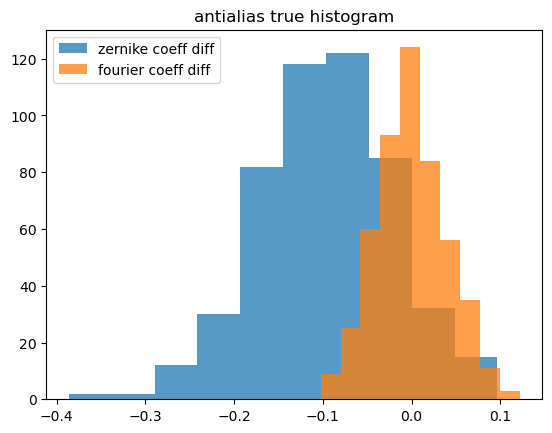

In [7]:
print(f'antialias: false\n\tfourier diff: {np.mean(diff_top_f)}\n\tzernike diff: {np.mean(diff_top_z)}')

plt.figure()
plt.title('antialias false histogram')
plt.hist(diff_top_z, alpha=0.75, label='zernike coeff diff')
plt.hist(diff_top_f, alpha=0.75, label='fourier coeff diff')
plt.legend()
plt.show()

print(f'antialias: true\n\tfourier diff: {np.mean(diff_bottom_f)}\n\tzernike diff: {np.mean(diff_bottom_z)}')

plt.figure()
plt.title('antialias true histogram')
plt.hist(diff_bottom_z, alpha=0.75, label='zernike coeff diff')
plt.hist(diff_bottom_f, alpha=0.75, label='fourier coeff diff')
plt.legend()
plt.show()